### LSTM / Customer Touchpoints Predictions

**How the customer journey problem is formulated historically?**

As a campaign planner, I would like to improve ROI of my campaign by identifying users’ potential for conversion. I would like to place this in a bigger context of their exposure as a journey, so I can better plan my campaign spending. Formulate customer journey problem in a broader context of sequence prediction problems.

**Use case specific requirements**

- Encoder input length: Longest input sequence observed at training time.
- Decoder target length: Longest target sequence observed at training time.
- Zero pad.
- Heuristic: No worries about termination as target sequence length is predetermined.

**Important Facts**
- The model will handle:
    - Arbitrary length of observed sequence as the cause.
    - The observed sequence may or may not already contain the touchpoint of interest (‘visit’)

- The model success criteria are:
    - Predict the effect as a touchpoint sequence.
    - The effect sequences are compared to the ground truth for presence of certain word (‘visit’).

- Take advantage of business rules to simplify the model:
    - Fixed length source sequence by padding.
    - Fixed length target sequence by padding.
    - Only want to predict the presence of ‘visit’ in target sequence.



### Data Structure
- Order touchpoints by timestamp for each user.
- Organize it as a text string.
- Split text string into sequences to create input sequence and target sequence.
- Predict target sequence given input sequence (hard to do it well).
- Business rule: Predict target sequence to contain word ‘visit’ given input sequence (easier).


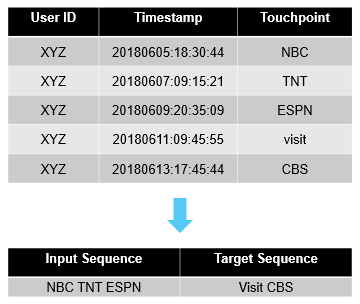

### Types of Sequence Models
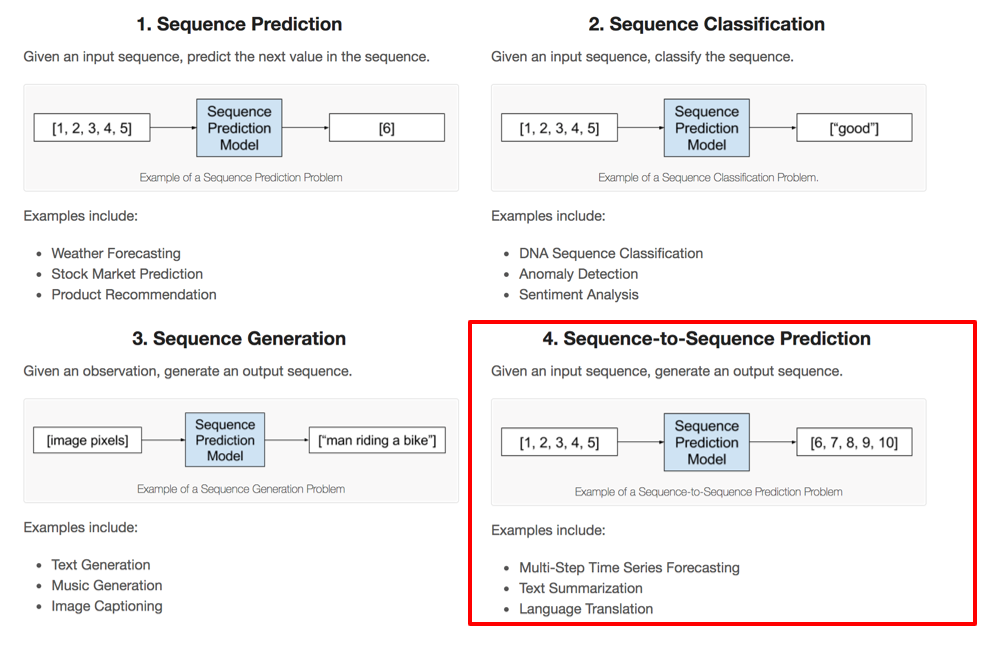

### General Process
- Tokenize events or entities.
- Remove infrequent events or entities (optional).
- Append special <start>, <end>, <unknown> token.
- Build vocab for encoder and decoder.


In [68]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


warnings.filterwarnings("ignore")

In [3]:
RANDOM_STATE = 23

### Data Preprocessing

**Important**
- Input and target sequence has been split using `\t` symbol
- Each token name is written without spaces (e.g. `SpikeTV `, `FoxSports1`, ...)

In [4]:
data_path = "data/small_train_data.csv"
columns = ['user_id', 'input_seq', 'target_seq']

data = pd.read_csv(data_path, sep='\t', names=columns)
data

,user_id,input_seq,target_seq
0,21018,ABC,Bravo E!
1,23393,Discovery,TLC
2,7123,FX TNT,AnimalPlanet TBS
3,39262,MTV2,MTV2
4,17459,CBS,NBC
...,...,...,...
49995,46223,CBS CW,ABC ESPN2 ESPN
49996,57465,NBC CBS,ABC visit
49997,12513,Discovery USANetwork ComedyCentral,truTV TBS ABC
49998,84481,ABC,NBC


In [5]:
# look at input and target seql len distribution
data['input_seq_len'] = data['input_seq'].apply(lambda x: len(x.split(' ')))
data['target_seq_len'] = data['target_seq'].apply(lambda x: len(x.split(' ')))


(
    data['input_seq_len'].value_counts(),
    data['target_seq_len'].value_counts()
)

(input_seq_len
 1     23791
 2     12036
 3      7651
 4      3935
 5      1687
 6       614
 7       199
 8        67
 9        15
 10        3
 12        1
 11        1
 Name: count, dtype: int64,
 target_seq_len
 1     16991
 2     13230
 3      9911
 4      5661
 5      2653
 6      1045
 7       344
 8       126
 9        28
 10        8
 11        2
 12        1
 Name: count, dtype: int64)

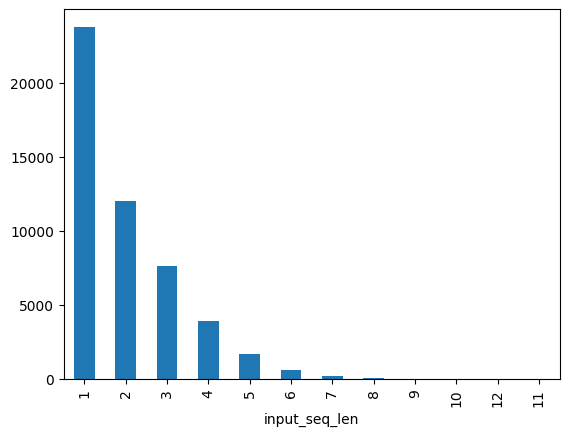

In [6]:
data['input_seq_len'].value_counts().plot(kind='bar');

In [7]:

# data_path = "data/small_train_data.csv"
# columns = ['user_id', 'seq_a', 'seq_b']

# data = pd.read_csv(data_path, sep='\t', names=columns)
# data['sequence'] = data['seq_a'] + ' ' + data['seq_b']
# data = data.drop(['seq_a', 'seq_b'], axis=1)
# data

**Train/Test Split**

In [8]:
train_data, remained = train_test_split(data, test_size=0.4, random_state=RANDOM_STATE) 
val_data, test_data = train_test_split(remained, test_size=0.5, random_state=RANDOM_STATE)

print('N Samples Total: ', data.shape[0])
print('N Samples Train: ', train_data.shape[0])
print('N Samples Validation: ', val_data.shape[0])
print('N Samples Test: ', test_data.shape[0])

N Samples Total:  50000
N Samples Train:  30000
N Samples Validation:  10000
N Samples Test:  10000


**Tokens Corpus Building**

In [9]:
# run on all data to build a corpus
input_sequences = []
target_sequences = []
input_tokens = set()
target_tokens = set()
sep = ' '

for row in data[['input_seq', 'target_seq']].values:
    try:
        input_seq, target_seq = row
        target_seq = '<start>' + " " + target_seq + " " + '<stop>'   
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
        for token in input_seq.split(sep=sep):
            if token not in input_tokens:
                input_tokens.add(token)
        for token in target_seq.split(sep=sep):
            if token not in target_tokens:
                target_tokens.add(token)
    except:
        pass

# build final vocab 
vocab = list(set(input_tokens).union(set(target_tokens)))

In [10]:
print('Input Sequences: \n', input_sequences[5:10], ',', len(input_sequences))
print('Target Sequences: \n', target_sequences[5:10], ',', len(target_sequences))

Input Sequences: 
 ['ESPN SpikeTV FoxSports1 CBS', 'visit', 'TNT NBC', 'NBC', 'ABC Discovery NBC'] , 50000
Target Sequences: 
 ['<start> FOX NBC ESPN2 CW <stop>', '<start> visit <stop>', '<start> CBS Bravo AMC <stop>', '<start> FOX <stop>', '<start> Bravo ESPN TBS <stop>'] , 50000


In [11]:
print('Input Tokens (Vocab Size): ', len(input_tokens))
print('Target Tokens (Vocab Size): ', len(target_tokens))
print('Vocab Size: ', len(vocab))

Input Tokens (Vocab Size):  44
Target Tokens (Vocab Size):  46
Vocab Size:  46


In [12]:
def create_corpus_dict(word_list):
    """Creates a corpus -> pair of word:index (token:index)"""
    corpus = dict([(word, i) for i, word in enumerate(word_list)])
    return corpus


corpus_dict = create_corpus_dict(vocab)
corpus_dict

{'CMT': 0,
 'ABC': 1,
 'ESPN': 2,
 'NBCUniverso': 3,
 'Bravo': 4,
 'MTV': 5,
 'TLC': 6,
 'FXX': 7,
 'Discovery': 8,
 'TNT': 9,
 'Univision(National)': 10,
 'FoxDeportes': 11,
 'truTV': 12,
 'web': 13,
 'Galavision': 14,
 'TVLand': 15,
 'BET': 16,
 '<stop>': 17,
 'CBS': 18,
 'CW': 19,
 'FX': 20,
 'MTV2': 21,
 'AnimalPlanet': 22,
 'FoxSports1': 23,
 'A&E': 24,
 'FOX': 25,
 'Telemundo(National)': 26,
 'Nickelodeon': 27,
 'AMC': 28,
 'USANetwork': 29,
 'visit': 30,
 'ComedyCentral': 31,
 'NationalGeographic': 32,
 'VH1': 33,
 'ESPNDeportes': 34,
 'NBCSportsNetwork': 35,
 'ESPN2': 36,
 'UniMas(National)': 37,
 'E!': 38,
 'CartoonNetwork': 39,
 '<start>': 40,
 'Freeform': 41,
 'SpikeTV': 42,
 'NBC': 43,
 'History': 44,
 'TBS': 45}

In [13]:
# create a function for adding special tokens
def add_start_stop_tokens(rows):
    input_sequences = []
    target_sequences = []
    try:
        for row in rows:
            input_seq, target_seq = row
            target_seq = '<start>' + " " + target_seq + " " + '<stop>'   
            input_sequences.append(input_seq)
            target_sequences.append(target_seq)
    except Exception as e:
        print(e)

    return input_sequences, target_sequences

### Data Transformation and Encoding 
Let's process the data that we split into required format

In [14]:
columns = ['input_seq', 'target_seq']

input_seq_train, target_seq_train = add_start_stop_tokens(train_data[columns].values)
input_seq_val, target_seq_val = add_start_stop_tokens(val_data[columns].values)
input_seq_test, target_seq_test = add_start_stop_tokens(test_data[columns].values)

In [15]:
# create function to get an idea of inut/target vocab size
def get_array_specs(input_texts, target_texts, input_vocab, target_vocab):
    
    # input and target may have different vocab and different token count.
    input_vocab = sorted(list(input_vocab))
    target_vocab = sorted(list(target_vocab))
    n_tokens_encoder = len(input_vocab)
    n_tokens_decoder = len(target_vocab)
    max_encoder_seq_length = max([len(txt.split()) for txt in input_texts]) # number of words in each string.
    max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])
    
    return n_tokens_encoder, n_tokens_decoder, max_encoder_seq_length, max_decoder_seq_length

In [16]:
# input and target use same vocab corpus (train data)
n_tokens_encoder_train, n_tokens_decoder_train, max_encoder_seq_length_train, max_decoder_seq_length_train = get_array_specs(
    input_seq_train, target_seq_train, vocab, vocab # since input and target vocab have the same vocab!
)

# process test data
n_tokens_encoder_test, n_tokens_decoder_test, max_encoder_seq_length_test, max_decoder_seq_length_test = get_array_specs(
    input_seq_test, target_seq_test, vocab, vocab
)

In [17]:
print('N Tokens (Encoder Train): ', n_tokens_encoder_train)
print('N Tokens (Decoder Train): ', n_tokens_decoder_train)

print('Max Sequence Length (Encoder Train): ', max_encoder_seq_length_train)
print('Max Sequence Length (Decoder Train): ', max_decoder_seq_length_train)


print('\nN Tokens (Encoder Test): ', n_tokens_encoder_test)
print('N Tokens (Decoder Test): ', n_tokens_decoder_test)

print('Max Sequence Length (Encoder Test): ', max_encoder_seq_length_test)
print('Max Sequence Length (Decoder Test): ', max_decoder_seq_length_test)

N Tokens (Encoder Train):  46
N Tokens (Decoder Train):  46
Max Sequence Length (Encoder Train):  11
Max Sequence Length (Decoder Train):  13

N Tokens (Encoder Test):  46
N Tokens (Decoder Test):  46
Max Sequence Length (Encoder Test):  12
Max Sequence Length (Decoder Test):  14


**Matrices Iitialization**

In [18]:
def get_encoder_decoder_zero_matrices(
    input_sequences,
    max_encoder_seq_length,
    max_decoder_seq_length,
    n_tokens_encoder,
    n_tokens_decoder
):
    encoder_input_data = np.zeros(
        (len(input_sequences), max_encoder_seq_length, n_tokens_encoder),
        dtype='float32'
    )
    decoder_input_data = np.zeros(
        (len(input_sequences), max_decoder_seq_length, n_tokens_decoder),
        dtype='float32'
    )
    decoder_target_data = np.zeros(
        (len(input_sequences), max_decoder_seq_length, n_tokens_decoder),
        dtype='float32'
    )
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [19]:
# train data
encoder_input_data_zero_train, decoder_input_data_zero_train, decoder_target_data_zero_train = get_encoder_decoder_zero_matrices(
    input_seq_train,
    max_encoder_seq_length_train,
    max_decoder_seq_length_train,
    n_tokens_encoder_train,
    n_tokens_decoder_train
)

print('Encoder Input Shape: ', encoder_input_data_zero_train.shape)
print('Decoder Input Shape: ', decoder_input_data_zero_train.shape)
print('Decoder Output Shape: ', decoder_target_data_zero_train.shape)

Encoder Input Shape:  (30000, 11, 46)
Decoder Input Shape:  (30000, 13, 46)
Decoder Output Shape:  (30000, 13, 46)


In [20]:
# test data
encoder_input_data_zero_test, decoder_input_data_zero_test, decoder_target_data_zero_test = get_encoder_decoder_zero_matrices(
    input_seq_test,
    max_encoder_seq_length_test,
    max_decoder_seq_length_test,
    n_tokens_encoder_test,
    n_tokens_decoder_test
)

print('Encoder Input Shape: ', encoder_input_data_zero_test.shape)
print('Decoder Input Shape: ', decoder_input_data_zero_test.shape)
print('Decoder Output Shape: ', decoder_target_data_zero_test.shape)

Encoder Input Shape:  (10000, 12, 46)
Decoder Input Shape:  (10000, 14, 46)
Decoder Output Shape:  (10000, 14, 46)


**One Hot Encoding**

In [21]:
def one_hot_encode(
    encoder_input_data,
    decoder_input_data,
    decoder_target_data,
    input_sequences,
    target_sequences,
    input_corpus,
    target_corpus
):
    for i, (input_sequence, target_sequence) in enumerate(zip(input_sequences, target_sequences)):
        for t, token in enumerate(input_sequence.split()):
            encoder_input_data[i, t, input_corpus[token]] = 1.
        for t, token in enumerate(target_sequence.split()):
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, target_corpus[token]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, target_corpus[token]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [22]:
# OHE Train 
encoder_input_data_train, decoder_input_data_train, decoder_target_data_train = one_hot_encode(
    encoder_input_data=encoder_input_data_zero_train,
    decoder_input_data=decoder_input_data_zero_train,
    decoder_target_data=decoder_target_data_zero_train,
    input_sequences=input_seq_train,
    target_sequences=target_seq_train,
    input_corpus=corpus_dict,
    target_corpus=corpus_dict
)

In [33]:
# OHE Test 
encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = one_hot_encode(
    encoder_input_data=encoder_input_data_zero_test,
    decoder_input_data=decoder_input_data_zero_test,
    decoder_target_data=decoder_target_data_zero_test,
    input_sequences=input_seq_test,
    target_sequences=target_seq_test,
    input_corpus=corpus_dict,
    target_corpus=corpus_dict
)

**Important**
- Incoder can process a sequence of 11 elements/tokens where each token is represented as OHE vector (1 - means what token is present in a sentence)
- Matrix `n_seq_len X n_tokens` describes single observation. We have N observations that creates a tensor of shape: `N X n_seq_len X n_tokens `  

In [24]:
# example, some data sampple
encoder_input_data_train[0][:5, :5]

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

### Encoder-Decoder Definition

In [25]:
N_LSTM_UNITS = 256
N_EPOCHS = 30
BATCH_SIZE = 64

In [26]:
# Encoder
encoder_inputs = Input(shape=(None, n_tokens_encoder_train))
encoder_lstm = LSTM(N_LSTM_UNITS, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c] # discard `encoder_outputs` and only keep the states.


# Decoder
decoder_inputs = Input(shape=(None, n_tokens_decoder_train))
decoder_lstm = LSTM(N_LSTM_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states) # we use states from encoder. We don't use return states in the training model, but we will use them in inference
decoder_dense = Dense(n_tokens_decoder_train, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

2024-05-18 19:45:15.950227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-18 19:45:15.950749: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [27]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "model"


__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 46)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 46)]           0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, 256),                310272    ['input_1[0][0]']             
                              (None, 256),                                                        
                              (None, 256)]                                                        
                                                                                                  
 lstm_1 (L

**Model Training**

In [28]:
early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5,            
    verbose=1,            
    restore_best_weights=True 
)

model.fit(
    [encoder_input_data, decoder_input_data], decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=N_EPOCHS,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=2
)


Epoch 1/30
125/125 - 11s - loss: 0.7367 - val_loss: 0.7147 - 11s/epoch - 91ms/step
Epoch 2/30
125/125 - 8s - loss: 0.6770 - val_loss: 0.6834 - 8s/epoch - 63ms/step
Epoch 3/30
125/125 - 9s - loss: 0.6640 - val_loss: 0.6729 - 9s/epoch - 70ms/step
Epoch 4/30
125/125 - 11s - loss: 0.6595 - val_loss: 0.6720 - 11s/epoch - 90ms/step
Epoch 5/30
125/125 - 8s - loss: 0.6573 - val_loss: 0.6714 - 8s/epoch - 65ms/step
Epoch 6/30
125/125 - 8s - loss: 0.6568 - val_loss: 0.6721 - 8s/epoch - 61ms/step
Epoch 7/30
125/125 - 8s - loss: 0.6572 - val_loss: 0.6712 - 8s/epoch - 60ms/step
Epoch 8/30
125/125 - 7s - loss: 0.6565 - val_loss: 0.6696 - 7s/epoch - 59ms/step
Epoch 9/30
125/125 - 7s - loss: 0.6560 - val_loss: 0.6715 - 7s/epoch - 60ms/step
Epoch 10/30
125/125 - 8s - loss: 0.6552 - val_loss: 0.6734 - 8s/epoch - 60ms/step
Epoch 11/30
125/125 - 8s - loss: 0.6579 - val_loss: 0.6849 - 8s/epoch - 61ms/step
Epoch 12/30
125/125 - 8s - loss: 0.6582 - val_loss: 0.6727 - 8s/epoch - 60ms/step
Epoch 13/30
125/125 -

### Model Inference
1. Encode input and retrieve initial decoder state
2. Run **one step** of decoder with this initial state and a "start of sequence" token as target. Output will be the next target token
3. Repeat with the current target token and current states

In [29]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(N_LSTM_UNITS, ))
decoder_state_input_c = Input(shape=(N_LSTM_UNITS, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

In [30]:
# reassign variables for convenience
input_token_index = corpus_dict
target_token_index = corpus_dict

In [31]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [34]:
# step 1: encoder model predicts states_value by using one-hot inputs.
states_value = encoder_model.predict(encoder_input_data_test)

313/313 [==============================] - 3s 8ms/step


In [80]:
# step 2: create a target_seq holder, with first position being initialized with the <start> token.
target_seq = np.zeros((encoder_input_data_test.shape[0], max_encoder_seq_length_test, n_tokens_decoder_test)) # generate empty target sequence of length 1.
target_seq[:, 0, target_token_index['<start>']] = 1. # populate the first character of target sequence with the <start> token.

print('Target Seq Shape: ', target_seq.shape)

Target Seq Shape:  (10000, 12, 46)


In [37]:
# step 3: decoder model can use target_seq holder and states_value to predict output_tokens, h, c.
output_tokens, h, c = decoder_model.predict([target_seq] + states_value) # output_tokens outputs probabilities

# step 4. decoder output_tokens go through argmax to get integer index.
integer_list = output_tokens.argmax(axis=2)

# step 5. integer index is used to do reverse lookup to get to the corresponding word.
translated_array = np.vectorize(reverse_input_char_index.get)(integer_list)

313/313 [==============================] - 3s 9ms/step


In [92]:
# look at predictions 
translated_array

array([['visit', '<stop>', '<stop>', ..., '<stop>', '<stop>', '<stop>'],
       ['CBS', '<stop>', '<stop>', ..., '<stop>', '<stop>', '<stop>'],
       ['NBC', '<stop>', '<stop>', ..., '<stop>', '<stop>', '<stop>'],
       ...,
       ['NBC', '<stop>', '<stop>', ..., '<stop>', '<stop>', '<stop>'],
       ['NBC', 'NBC', '<stop>', ..., '<stop>', '<stop>', '<stop>'],
       ['NBC', '<stop>', '<stop>', ..., '<stop>', '<stop>', '<stop>']],
      dtype='<U10')

- Model predicted N tokens according to predicted sequence length

In [95]:
# remove <start> and <stop> from prediction
translated_list = translated_array.tolist()
stop_word_list = ['<start>', '<stop>']
truncated_list = []

def extract_items(translated_words_list, exclusion_word_list):
    return [item for item in translated_words_list if item not in exclusion_word_list]

for a_list in translated_list:
    truncated_list.append(extract_items(a_list, stop_word_list))

print('Truncated Predictions: ', truncated_list[:5])


# create prediction by simply joining predicted tokens
predicted_list = []
for small_list in truncated_list:
    small_list_str = ' '.join(small_list)
    predicted_list.append(small_list_str)

print('Model Predictions: ', truncated_list[:5])

Truncated Predictions:  [['visit'], ['CBS'], ['NBC'], ['CBS'], ['NBC']]
Model Predictions:  [['visit'], ['CBS'], ['NBC'], ['CBS'], ['NBC']]


- Model was training using `input_seq_train` and `target_seq_train`
- Once model has been trained, we inserted `input_seq_test` to get the predictions from decoder and compare those predictions with `target_seq_test`

In [103]:
print('Input Sequence Test: ', input_seq_test[:5])
print('Predicted Sequence Test: ', truncated_list[:5])
print('Actual Sequence Test: ', target_seq_test[:5])

Input Sequence Test:  ['visit', 'NBC ABC', 'ABC', 'NBC ABC', 'CBS']
Predicted Sequence Test:  [['visit'], ['CBS'], ['NBC'], ['CBS'], ['NBC']]
Actual Sequence Test:  ['<start> visit <stop>', '<start> FXX FX <stop>', '<start> FOX CBS <stop>', '<start> MTV MTV2 <stop>', '<start> CBS <stop>']


In [104]:
truth_holder = []
for item in target_seq_test:
    words = ''
    for word in item.split(' '):
        if word not in stop_word_list:
            words += ' '
            words += word
            
    truth_holder.append(words)

assert len(truth_holder) == len(predicted_list) 

In [106]:
s = len(predicted_list)
holdout_results_holder = np.zeros((s, 3), dtype='int8') # columns will be actual, predicted, tabulation

target_word = 'visit'
for i, (truth_target_texts, predicted_sentence) in enumerate(zip(truth_holder, predicted_list)):
      #print('i= %s, sentence = %s' % (i,predicted_sentence))
  
      truth_string = ''.join(truth_holder)
      eval_string = ''.join(predicted_list)
  
      if target_word in truth_string:
          holdout_results_holder[i][0] = 1
    
      if target_word in eval_string:
          holdout_results_holder[i][1] = 1
    
      if holdout_results_holder[i][0] == holdout_results_holder[i][1]:
          holdout_results_holder[i][-1] = 1

In [108]:
def compare_to_reference(truth_text_list, predicted_text_list, target_word):
  # two lists has to have same number of elements.
  # search for target word in each sentence list.
  # last column is labeled if target_word's condition is same in both lists.
  assert len(truth_text_list) == len(predicted_text_list)
  
  s = len(predicted_text_list)
  holdout_results_holder = np.zeros((s, 3), dtype='int8') # columns are actual, predicted, tabulation


  for i, (truth_target_texts, predicted_sentence) in enumerate(zip(truth_text_list, predicted_text_list)):
      #print('i= %s, sentence = %s' % (i,predicted_sentence))
  
      truth_string = ''.join(truth_target_texts)
      eval_string = ''.join(predicted_sentence)
  
      if target_word in truth_string:
          holdout_results_holder[i][0] = 1
    
      if target_word in eval_string:
          holdout_results_holder[i][1] = 1
    
      if holdout_results_holder[i][0] == holdout_results_holder[i][1]:
          holdout_results_holder[i][-1] = 1
  
  return holdout_results_holder

In [109]:
comp = compare_to_reference(truth_holder, predicted_list, 'visit')

def print_classification_report(truth, predicted, target_names_list):
    from sklearn.metrics import classification_report
    # for printing performance of a classifier.
    print(classification_report(truth, predicted, target_names = target_names_list))

In [111]:
df = pd.DataFrame(data=comp, columns = ["visited", "predicted", "tabulation"])
y_actu = pd.Series(df['visited'], name='Actual')
y_pred = pd.Series(df['predicted'], name = 'Predicted')

In [112]:
dl_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
dl_confusion

Predicted,0,1,All
Actual,,,
0,7369,0,7369
1,1569,1062,2631
All,8938,1062,10000


In [113]:
predicted_results = y_pred.tolist()
truth = y_actu.tolist()
print(classification_report(truth, predicted_results))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      7369
           1       1.00      0.40      0.58      2631

    accuracy                           0.84     10000
   macro avg       0.91      0.70      0.74     10000
weighted avg       0.87      0.84      0.82     10000

